1.ModernICNet
2.ModernICNet --res drop the res connection after conv_s and ffn_c ffn_v add a res after the whole block
3.ModernTCN --res drop like 2 replace IsometricConv with common Conv1d
4.ICNet --drop channel_dim
5.ModernICNet-BN+LN --replace bn with ln
6.ModernICnet-ConvFNN+MlpFNN --replace ConvFNN with MLP 

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from sklearn import metrics
from einops import rearrange

In [5]:
class my_Dataset(Data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

class WheelRailTrajectoryDataset:
    def __init__(self,label=3):
        standard_scaler = StandardScaler()
        self.raw_data1 = pd.read_csv("../dataset/curve_R400.csv")
        self.raw_data2 = pd.read_csv("../dataset/curve_R1000.csv")
        self.raw_data3 = pd.read_csv("../dataset/curve_R2000.csv")
        self.raw_data4 = pd.read_csv("../dataset/curve_R3000.csv")
        self.raw_data5 = pd.read_csv("../dataset/curve_R4000.csv")
        self.raw_data6 = pd.read_csv("../dataset/curve_R5000.csv")
        self.raw_data = pd.concat([self.raw_data1,self.raw_data2,self.raw_data3,self.raw_data4,self.raw_data5,self.raw_data6])
        self.label = label
        #标准化
        self.data = standard_scaler.fit_transform(self.raw_data)
        self.mean = standard_scaler.mean_[label]
        self.sd = math.sqrt(standard_scaler.var_[label])


    def construct_set(self, train_por=0.6,val_por=0.2,test_por=0.2, window_size=100):
        X = []
        Y = []
        list = [self.raw_data1.shape[0],self.raw_data2.shape[0],self.raw_data3.shape[0],self.raw_data4.shape[0],self.raw_data5.shape[0],self.raw_data6.shape[0]]
        num = 0
        for j in range(len(list)):
            if j!=0:
                num = num+list[j-1]
            for i in range(list[j]-window_size):
                seq = self.data[num+i:num+i+window_size+1]
                X.append(seq[0:window_size,:self.label])
                y = seq[window_size:window_size+1,self.label]
                if(y>0.6 or y<-0.6):
                    Y.append(1)
                else:
                    Y.append(0)
        X = np.array(X)
        Y = np.array(Y)
        print(X.shape)
        print(Y.shape)
        train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=test_por,train_size=train_por+val_por,shuffle=True)
        train_x,val_x,train_y,val_y =  train_test_split(train_x,train_y,test_size=val_por/(val_por+train_por),train_size=train_por/(val_por+train_por),shuffle=True)

        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set

TrajectoryData = WheelRailTrajectoryDataset()
train_set, val_set, test_set = TrajectoryData.construct_set()
batch_size = 256
train_loader = Data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = Data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = Data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

(227406, 100, 3)
(227406,)


In [6]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model,seq_len = 100):
        super(PositionalEncoding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(seq_len, d_model+1)
        #维数 seq_len X d_model
        position = torch.arange(0, seq_len).unsqueeze(1) #  维数 seq_lenX1
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        #维数 dmodel/2
        pe[:, 0::2] = torch.sin(position * div_term)
        #维数 seq_len X dmodel/2
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        #维数 1Xseq_lenXd_model
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x batch_size X seq_len X num_features
        #print("x:",x.shape)
        #print("pe:",self.pe.shape)
        x = x + Variable(self.pe[:,:,:x.shape[-1]], requires_grad=False)
        return x

def evaluate_accuracy(data_iter, net, loss,device="cuda"):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        y_hat = y_hat.squeeze()
        acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        l = loss(y_hat, y.long()).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum/n, test_l_sum/n

def visualization(train_loss,val_loss,train_accuracy,val_accuracy):
    plt.figure(1)
    x1=np.linspace(0,len(train_loss),len(train_loss))
    plt.plot(x1,train_loss,label='train_loss',linewidth=1.5)
    plt.plot(x1,val_loss,label='test_loss',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

    plt.figure(2)
    x2 = np.linspace(0,len(train_accuracy),len(train_accuracy))
    plt.plot(x2,train_accuracy,label='train_accuracy',linewidth=1.5)
    plt.plot(x2,val_accuracy,label='val_accuracy',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

def evaluate_PR(data_iter, net, loss,device="cuda"):
    n = 0
    precision_sum,recall_sum,f1_score_sum = 0.0,0.0,0.0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y.long()).sum()
        y_hat = y_hat.argmax(dim=1)
        y_hat = y_hat.squeeze().cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        precision_sum += metrics.precision_score(y,y_hat)
        recall_sum += metrics.recall_score(y,y_hat)
        f1_score_sum += metrics.f1_score(y,y_hat)
        test_l_sum += l.item()
        #n += y.shape[0]
        n+=1
    return precision_sum/n,recall_sum/n,f1_score_sum/n

device = torch.device("cuda")
lr = 0.0001
epochs=300
loss=nn.CrossEntropyLoss()


1.ModernICNet

epoch1,loss0.0020,train acc 0.788042,val acc 0.814
epoch2,loss0.0019,train acc 0.830555,val acc 0.835
epoch3,loss0.0018,train acc 0.841261,val acc 0.853
epoch4,loss0.0018,train acc 0.847326,val acc 0.853
epoch5,loss0.0018,train acc 0.848743,val acc 0.855
epoch6,loss0.0018,train acc 0.855895,val acc 0.847
epoch7,loss0.0017,train acc 0.858259,val acc 0.867
epoch8,loss0.0017,train acc 0.864728,val acc 0.865
epoch9,loss0.0017,train acc 0.865939,val acc 0.875
epoch10,loss0.0017,train acc 0.870323,val acc 0.866
epoch11,loss0.0017,train acc 0.874053,val acc 0.881
epoch12,loss0.0017,train acc 0.876821,val acc 0.883
epoch13,loss0.0017,train acc 0.880206,val acc 0.887
epoch14,loss0.0017,train acc 0.882967,val acc 0.884
epoch15,loss0.0016,train acc 0.887512,val acc 0.892
epoch16,loss0.0016,train acc 0.888180,val acc 0.892
epoch17,loss0.0016,train acc 0.893694,val acc 0.896
epoch18,loss0.0016,train acc 0.893885,val acc 0.892
epoch19,loss0.0016,train acc 0.896227,val acc 0.898
epoch20,loss0.0016,tr

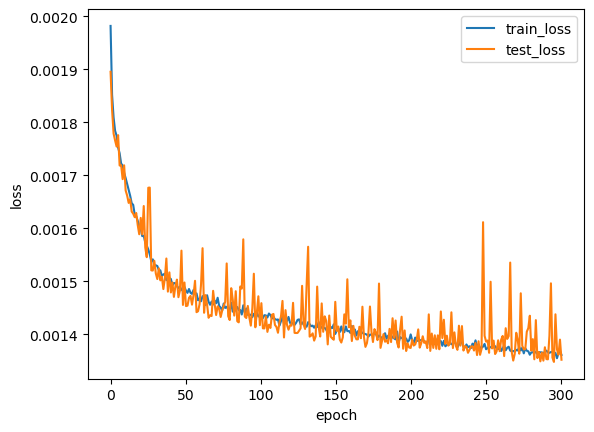

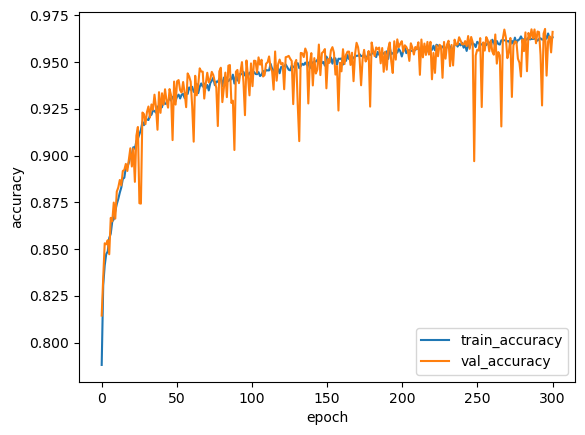

Accuracy on test set : 0.967
test precision: 0.958475234939564  test recall: 0.9615093289465897  test f1_score: 0.9597721044517872


In [7]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim):
        super(Embedding,self).__init__()
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=seq_len,padding=0,stride=1,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        zeros = torch.zeros((x.shape[0], x.shape[1], x.shape[2]-1),device='cuda')
        x = torch.cat((zeros, x), dim=-1)
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernICBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernICBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,
                                kernel_size=seq_len,padding=0,stride=1,groups=variable_dim*channel_dim)

        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.Tanh()
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.Tanh()
        )

        self.norm_1 = nn.BatchNorm1d(variable_dim*channel_dim)
        self.norm_2 = nn.BatchNorm1d(variable_dim*channel_dim)
        self.norm_3 = nn.BatchNorm1d(channel_dim*variable_dim)


    def isometric_conv(self,x):
        #batch_size feature_size seq_len
        zeros = torch.zeros((x.shape[0], x.shape[1], x.shape[2]-1),device='cuda')
        x = torch.cat((zeros, x), dim=-1)
        out = self.conv_s(x)
        return out

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.isometric_conv(x)
        y = self.norm_1(y + residual)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = self.norm_2(z + residual)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = self.norm_3(out + residual)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernICNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernICNet,self).__init__()
        self.pe = PositionalEncoding(variable_dim)
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernICList = nn.ModuleList([ModernICBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.linear = nn.Linear(channel_dim*seq_len,seq_len)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len,out_features=variable_dim*seq_len//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = x+self.pe(x)
        x = self.emb(x) # b v c s
        residual = x # b v c s
        features = x
        for block in self.ModernICList:
            features = block(features)
        features = features + residual
        features = rearrange(features,'b v c s -> b v (c s)')
        features = self.linear(features) # b v s
        features = self.flatten(features) # b (v*s)
        out = self.classifier(features)
        return out



def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernICNet_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernICNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernICNet_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))

test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

2.ModernICNet --res drop the res connection after conv_s and ffn_c ffn_v add a res after the whole block

epoch1,loss0.0020,train acc 0.794122,val acc 0.827
epoch2,loss0.0019,train acc 0.822780,val acc 0.835
epoch3,loss0.0018,train acc 0.838441,val acc 0.840
epoch4,loss0.0018,train acc 0.845343,val acc 0.850
epoch5,loss0.0018,train acc 0.851071,val acc 0.842
epoch6,loss0.0018,train acc 0.856790,val acc 0.865
epoch7,loss0.0017,train acc 0.863435,val acc 0.871
epoch8,loss0.0017,train acc 0.866747,val acc 0.873
epoch9,loss0.0017,train acc 0.868627,val acc 0.872
epoch10,loss0.0017,train acc 0.873289,val acc 0.881
epoch11,loss0.0017,train acc 0.875977,val acc 0.881
epoch12,loss0.0017,train acc 0.876109,val acc 0.881
epoch13,loss0.0017,train acc 0.878297,val acc 0.882
epoch14,loss0.0017,train acc 0.883495,val acc 0.889
epoch15,loss0.0017,train acc 0.882592,val acc 0.887
epoch16,loss0.0016,train acc 0.886968,val acc 0.894
epoch17,loss0.0016,train acc 0.888231,val acc 0.870
epoch18,loss0.0016,train acc 0.890478,val acc 0.893
epoch19,loss0.0016,train acc 0.893070,val acc 0.898
epoch20,loss0.0016,tr

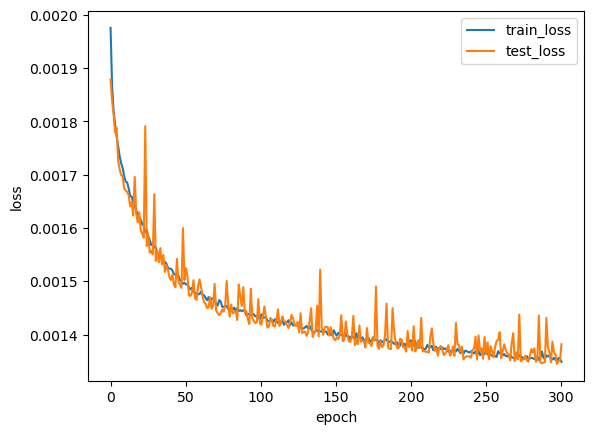

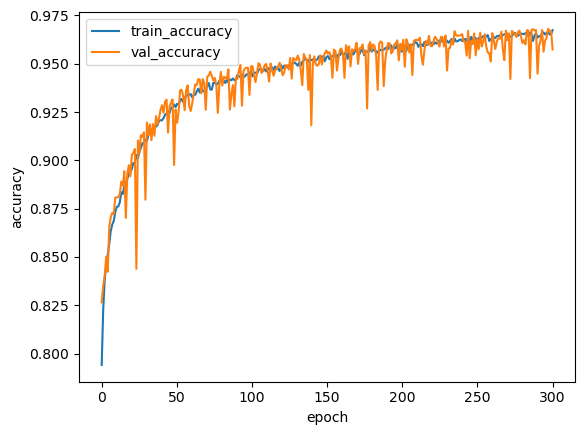

Accuracy on test set : 0.969
test precision: 0.9551570028384097  test recall: 0.9691095550388101  test f1_score: 0.9618735193419923


In [8]:
class ModernICBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernICBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,
                                kernel_size=seq_len,padding=0,stride=1,groups=variable_dim*channel_dim)

        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.Tanh()
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.Tanh()
        )
        
        self.norm = nn.BatchNorm1d(variable_dim*channel_dim)
        


    def isometric_conv(self,x):
        #batch_size feature_size seq_len
        zeros = torch.zeros((x.shape[0], x.shape[1], x.shape[2]-1),device='cuda')
        x = torch.cat((zeros, x), dim=-1)
        out = self.conv_s(x)
        return out

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]
        residual = x
        x = rearrange(x, 'b v c s -> b (v c) s')
        y = self.isometric_conv(x)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        z = self.ffn_c(y)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        out = self.ffn_v(z)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        out = out + residual # b v c s
        out = rearrange(out, 'b v c s -> b (v c) s')
        out = self.norm(out)
        out = rearrange(out,'b (v c) s -> b v c s', v=v)
        return out

class ModernICNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernICNet,self).__init__()
        self.pe = PositionalEncoding(variable_dim)
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernICList = nn.ModuleList([ModernICBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.linear = nn.Linear(channel_dim*seq_len,seq_len)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len,out_features=variable_dim*seq_len//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = x+self.pe(x)
        x = self.emb(x) # b v c s
        residual = x # b v c s
        features = x
        for block in self.ModernICList:
            features = block(features)
        features = features + residual
        features = rearrange(features,'b v c s -> b v (c s)')
        features = self.linear(features) # b v s
        features = self.flatten(features) # b (v*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernICNet_res_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernICNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernICNet_res_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))

test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

3.ModernTCN --res drop like 2 replace IsometricConv with common Conv1d

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:1009.)
  return F.conv1d(input, weight, bias, self.stride,


epoch1,loss0.0020,train acc 0.792844,val acc 0.820
epoch2,loss0.0018,train acc 0.840424,val acc 0.848
epoch3,loss0.0017,train acc 0.860844,val acc 0.875
epoch4,loss0.0017,train acc 0.866953,val acc 0.874
epoch5,loss0.0017,train acc 0.870822,val acc 0.878
epoch6,loss0.0017,train acc 0.872320,val acc 0.881
epoch7,loss0.0017,train acc 0.874420,val acc 0.881
epoch8,loss0.0017,train acc 0.877511,val acc 0.883
epoch9,loss0.0017,train acc 0.878701,val acc 0.857
epoch10,loss0.0017,train acc 0.880999,val acc 0.888
epoch11,loss0.0017,train acc 0.883855,val acc 0.885
epoch12,loss0.0017,train acc 0.885368,val acc 0.890
epoch13,loss0.0016,train acc 0.886073,val acc 0.895
epoch14,loss0.0016,train acc 0.888488,val acc 0.896
epoch15,loss0.0016,train acc 0.889766,val acc 0.886
epoch16,loss0.0016,train acc 0.892534,val acc 0.896
epoch17,loss0.0016,train acc 0.896345,val acc 0.890
epoch18,loss0.0016,train acc 0.895721,val acc 0.900
epoch19,loss0.0016,train acc 0.899208,val acc 0.906
epoch20,loss0.0016,tr

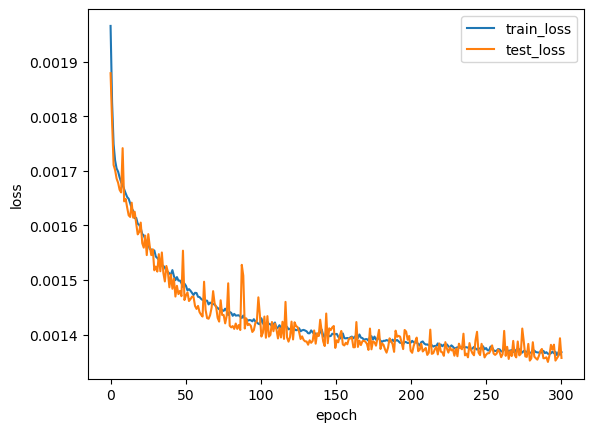

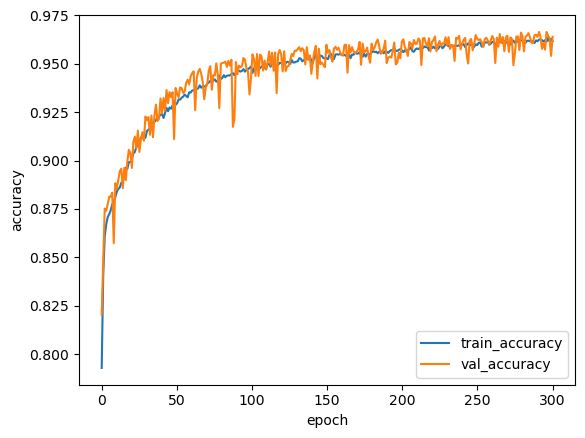

Accuracy on test set : 0.965
test precision: 0.957557110366753  test recall: 0.9576829234592386  test f1_score: 0.9574009606519911


In [10]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim):
        super(Embedding,self).__init__()
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=1,padding='same',stride=1,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernICBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernICBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,
                                kernel_size=10,padding='same',stride=1,groups=variable_dim*channel_dim)

        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.Tanh()
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.Tanh()
        )

        self.norm_1 = nn.BatchNorm1d(variable_dim*channel_dim)
        self.norm_2 = nn.BatchNorm1d(variable_dim*channel_dim)
        self.norm_3 = nn.BatchNorm1d(channel_dim*variable_dim)


    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.conv_s(x)
        y = self.norm_1(y + residual)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = self.norm_2(z + residual)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = self.norm_3(out + residual)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernICNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernICNet,self).__init__()
        self.pe = PositionalEncoding(variable_dim)
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernICList = nn.ModuleList([ModernICBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.linear = nn.Linear(channel_dim*seq_len,seq_len)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len,out_features=variable_dim*seq_len//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = x+self.pe(x)
        x = self.emb(x) # b v c s
        residual = x # b v c s
        features = x
        for block in self.ModernICList:
            features = block(features)
        features = features + residual
        features = rearrange(features,'b v c s -> b v (c s)')
        features = self.linear(features) # b v s
        features = self.flatten(features) # b (v*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernConv_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernICNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernConv_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

4.ICNet --drop channel_dim

epoch1,loss0.0022,train acc 0.713772,val acc 0.776
epoch2,loss0.0020,train acc 0.782931,val acc 0.783
epoch3,loss0.0020,train acc 0.788497,val acc 0.790
epoch4,loss0.0019,train acc 0.791963,val acc 0.792
epoch5,loss0.0019,train acc 0.794562,val acc 0.794
epoch6,loss0.0019,train acc 0.796831,val acc 0.798
epoch7,loss0.0019,train acc 0.797271,val acc 0.797
epoch8,loss0.0019,train acc 0.799555,val acc 0.798
epoch9,loss0.0019,train acc 0.801596,val acc 0.800
epoch10,loss0.0019,train acc 0.801949,val acc 0.803
epoch11,loss0.0019,train acc 0.802727,val acc 0.804
epoch12,loss0.0019,train acc 0.804019,val acc 0.806
epoch13,loss0.0019,train acc 0.802955,val acc 0.806
epoch14,loss0.0019,train acc 0.804056,val acc 0.803
epoch15,loss0.0019,train acc 0.805884,val acc 0.808
epoch16,loss0.0019,train acc 0.806597,val acc 0.806
epoch17,loss0.0019,train acc 0.797822,val acc 0.799
epoch18,loss0.0019,train acc 0.803094,val acc 0.807
epoch19,loss0.0019,train acc 0.805055,val acc 0.810
epoch20,loss0.0019,tr

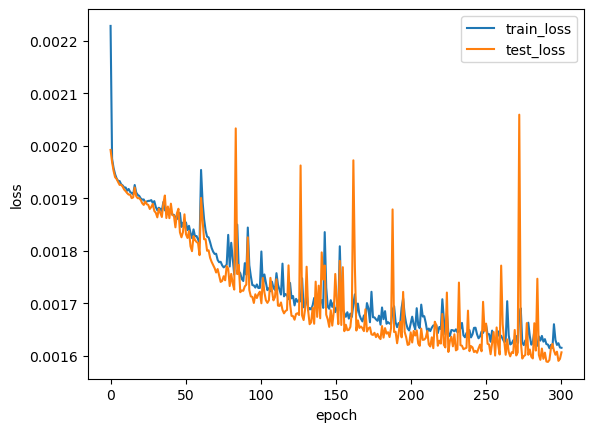

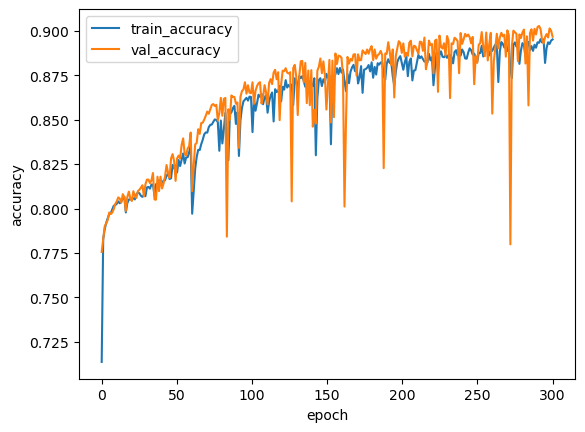

在测试集上的准确率为:0.898
test precision: 0.8871702412195257  test recall: 0.8583683553122041  test f1_score: 0.8720919051406903


In [11]:
class IsometricConvBlock(nn.Module):
    def __init__(self,input_dim,mlp_dim,input_length):
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=mlp_dim,padding='same',kernel_size=1),
            nn.GELU(),
            nn.Conv1d(in_channels=mlp_dim, out_channels=input_dim,padding='same',kernel_size=1),
            nn.Tanh()
        )
        self.norm_1 = nn.LayerNorm(input_dim)
        self.norm_2 = nn.LayerNorm(input_dim)
        #Conv1d要求输入为batch_size*features*seq_length
        self.conv = nn.Conv1d(in_channels=input_dim, out_channels=input_dim,
                              kernel_size=input_length,padding=0,stride=1,groups=3)
    def isometric_conv(self,x):
        #batch_size feature_size seq_len
        zeros = torch.zeros((x.shape[0], x.shape[1], x.shape[2]-1),device='cuda')
        x = torch.cat((zeros, x), dim=-1)
        out = self.conv(x)
        return out

    def forward(self,x):
        #input : batch_size seq_len feature_size
        residual = x
        x  = x.permute(0,2,1)
        #batch_size feature_size seq_len
        x = self.isometric_conv(x)
        x = x.permute(0,2,1)
        x = self.norm_1(x + residual)
        residual = x
        x = x.permute(0,2,1)
        x = self.ffn(x)
        x = x.permute(0,2,1)
        out = self.norm_2(x + residual)
        return out

class ICNet(nn.Module):
    def __init__(self,num_i,feature_dim,mlp_dim,seq_len):
        super().__init__()
        self.pe = PositionalEncoding(3)
        self.IsometricConvList = nn.ModuleList([IsometricConvBlock(feature_dim,mlp_dim,seq_len) for _ in range(num_i)])
        self.channel_interaction = nn.Sequential(
            nn.Linear(in_features=feature_dim,out_features=feature_dim*16),
            nn.GELU(),
            nn.Linear(in_features=feature_dim*16,out_features=1),
            nn.Dropout(0.1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=seq_len,out_features=seq_len//2),
            nn.GELU(),
            nn.Linear(in_features=seq_len//2,out_features=2),
            nn.Sigmoid()
        )
        self.norm = nn.LayerNorm(feature_dim)

    def forward(self,x):
        x = x+self.pe(x)
        residual = x
        i_features = x
        for Iblock in self.IsometricConvList:
            i_features = Iblock(i_features)
        i_features = self.norm(i_features+residual)
        y = self.channel_interaction(i_features).squeeze()
        y = self.classifier(y)
        return y

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ICNet_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ICNet(3,3,36,100)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)
train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ICNet_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("在测试集上的准确率为:%.3f"%(test_acc))
test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

5.ModernICNet-BN+LN --replace bn with ln

epoch1,loss0.0020,train acc 0.787190,val acc 0.821
epoch2,loss0.0019,train acc 0.827985,val acc 0.833
epoch3,loss0.0018,train acc 0.846533,val acc 0.856
epoch4,loss0.0018,train acc 0.853714,val acc 0.860
epoch5,loss0.0018,train acc 0.856254,val acc 0.822
epoch6,loss0.0017,train acc 0.858450,val acc 0.863
epoch7,loss0.0017,train acc 0.862195,val acc 0.873
epoch8,loss0.0017,train acc 0.865227,val acc 0.869
epoch9,loss0.0017,train acc 0.870925,val acc 0.873
epoch10,loss0.0017,train acc 0.873957,val acc 0.880
epoch11,loss0.0017,train acc 0.876784,val acc 0.873
epoch12,loss0.0017,train acc 0.880184,val acc 0.883
epoch13,loss0.0017,train acc 0.884655,val acc 0.887
epoch14,loss0.0016,train acc 0.886785,val acc 0.894
epoch15,loss0.0016,train acc 0.888106,val acc 0.884
epoch16,loss0.0016,train acc 0.891198,val acc 0.898
epoch17,loss0.0016,train acc 0.895699,val acc 0.900
epoch18,loss0.0016,train acc 0.897512,val acc 0.900
epoch19,loss0.0016,train acc 0.899201,val acc 0.901
epoch20,loss0.0016,tr

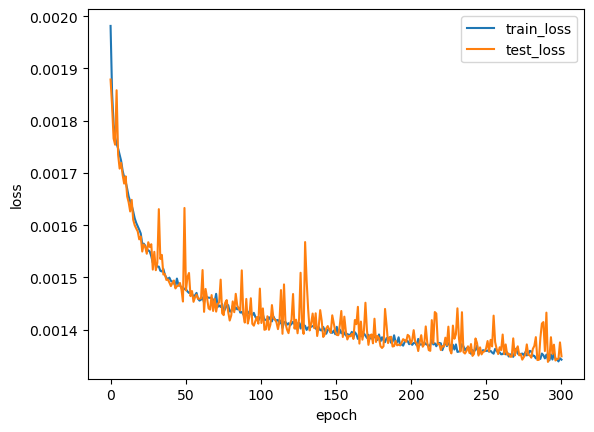

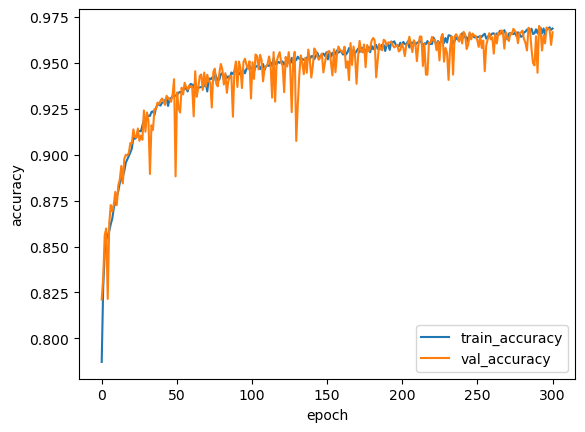

Accuracy on test set : 0.972
test precision: 0.9772508155537755  test recall: 0.9534464790577982  test f1_score: 0.9650284937346935


In [13]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim):
        super(Embedding,self).__init__()
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=seq_len,padding=0,stride=1,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        zeros = torch.zeros((x.shape[0], x.shape[1], x.shape[2]-1),device='cuda')
        x = torch.cat((zeros, x), dim=-1)
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernICBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernICBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,
                                kernel_size=seq_len,padding=0,stride=1,groups=variable_dim*channel_dim)

        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.Tanh()
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.Tanh()
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)


    def isometric_conv(self,x):
        #batch_size feature_size seq_len
        zeros = torch.zeros((x.shape[0], x.shape[1], x.shape[2]-1),device='cuda')
        x = torch.cat((zeros, x), dim=-1)
        out = self.conv_s(x)
        return out

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.isometric_conv(x)
        y = y + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernICNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernICNet,self).__init__()
        self.pe = PositionalEncoding(variable_dim)
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernICList = nn.ModuleList([ModernICBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.linear = nn.Linear(channel_dim*seq_len,seq_len)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len,out_features=variable_dim*seq_len//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = x+self.pe(x)
        x = self.emb(x) # b v c s
        residual = x # b v c s
        features = x
        for block in self.ModernICList:
            features = block(features)
        features = features + residual
        features = rearrange(features,'b v c s -> b v (c s)')
        features = self.linear(features) # b v s
        features = self.flatten(features) # b (v*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernICNet_LN_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernICNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernICNet_LN_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))

test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

6.ModernICnet-ConvFNN+MlpFNN --replace ConvFNN with MLP 

epoch1,loss0.0020,train acc 0.794547,val acc 0.830
epoch2,loss0.0018,train acc 0.833235,val acc 0.850
epoch3,loss0.0018,train acc 0.843757,val acc 0.852
epoch4,loss0.0018,train acc 0.853685,val acc 0.859
epoch5,loss0.0017,train acc 0.857635,val acc 0.866
epoch6,loss0.0017,train acc 0.863861,val acc 0.870
epoch7,loss0.0017,train acc 0.868370,val acc 0.862
epoch8,loss0.0017,train acc 0.873598,val acc 0.866
epoch9,loss0.0017,train acc 0.876226,val acc 0.885
epoch10,loss0.0017,train acc 0.884112,val acc 0.890
epoch11,loss0.0016,train acc 0.887563,val acc 0.893
epoch12,loss0.0016,train acc 0.891866,val acc 0.902
epoch13,loss0.0016,train acc 0.894384,val acc 0.892
epoch14,loss0.0016,train acc 0.896088,val acc 0.884
epoch15,loss0.0016,train acc 0.898349,val acc 0.898
epoch16,loss0.0016,train acc 0.901110,val acc 0.911
epoch17,loss0.0016,train acc 0.903563,val acc 0.911
epoch18,loss0.0016,train acc 0.905295,val acc 0.914
epoch19,loss0.0016,train acc 0.909011,val acc 0.903
epoch20,loss0.0016,tr

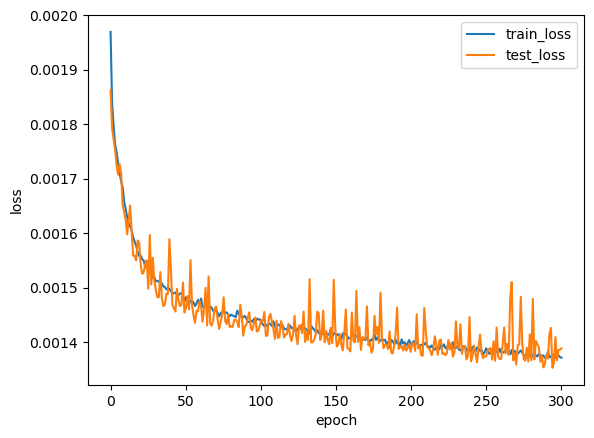

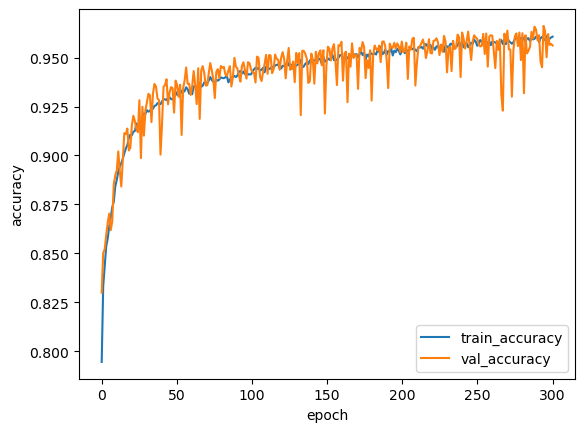

Accuracy on test set : 0.964
test precision: 0.9615015623104081  test recall: 0.9518907151616625  test f1_score: 0.9564386145455245


In [14]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim):
        super(Embedding,self).__init__()
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=seq_len,padding=0,stride=1,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        zeros = torch.zeros((x.shape[0], x.shape[1], x.shape[2]-1),device='cuda')
        x = torch.cat((zeros, x), dim=-1)
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernICBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernICBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,
                                kernel_size=seq_len,padding=0,stride=1,groups=variable_dim*channel_dim)

        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Linear(variable_dim*channel_dim,r*variable_dim*channel_dim),
            nn.GELU(),
            nn.Linear(r*variable_dim*channel_dim,variable_dim*channel_dim),
            nn.Tanh()
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Linear(variable_dim*channel_dim,r*variable_dim*channel_dim),
            nn.GELU(),
            nn.Linear(r*variable_dim*channel_dim,variable_dim*channel_dim),
            nn.Tanh()
        )

        self.norm_1 = nn.BatchNorm1d(variable_dim*channel_dim)
        self.norm_2 = nn.BatchNorm1d(variable_dim*channel_dim)
        self.norm_3 = nn.BatchNorm1d(channel_dim*variable_dim)


    def isometric_conv(self,x):
        #batch_size feature_size seq_len
        zeros = torch.zeros((x.shape[0], x.shape[1], x.shape[2]-1),device='cuda')
        x = torch.cat((zeros, x), dim=-1)
        out = self.conv_s(x)
        return out

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.isometric_conv(x)
        y = self.norm_1(y + residual)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        y = y.permute(0,2,1)
        z = self.ffn_c(y) #
        z = z.permute(0,2,1)
        z = self.norm_2(z + residual)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        z = z.permute(0,2,1)
        out = self.ffn_v(z)
        out = out.permute(0,2,1)
        out = self.norm_3(out + residual)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernICNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernICNet,self).__init__()
        self.pe = PositionalEncoding(variable_dim)
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernICList = nn.ModuleList([ModernICBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.linear = nn.Linear(channel_dim*seq_len,seq_len)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len,out_features=variable_dim*seq_len//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = x+self.pe(x)
        x = self.emb(x) # b v c s
        residual = x # b v c s
        features = x
        for block in self.ModernICList:
            features = block(features)
        features = features + residual
        features = rearrange(features,'b v c s -> b v (c s)')
        features = self.linear(features) # b v s
        features = self.flatten(features) # b (v*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernICNet_MLP_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernICNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernICNet_MLP_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))

test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)